
### Complete trained model with all features available 

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pycaret.classification import * # Machine learning tools
import imblearn  # Resampling
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import ConfusionMatrixDisplay # Model evaluation
import matplotlib.pyplot as plt # Visualization
from sklearn.metrics import classification_report # Model evaluation report


In [3]:
#Cargamos el dataset desde nuestro directorio de trabajo
#Working directory
#df = pd.read_csv("DATA/20240812_vortex_trainning_float_formmated.csv", encoding='latin-1') 
df = pd.read_excel('/home/dsg/VORTEX_FINAL/PRODUCTION/DATA/processed/final_input_data.xlsx', engine='openpyxl')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1778 non-null   int64  
 1   Al          1778 non-null   float64
 2   Si          1778 non-null   float64
 3   P           1778 non-null   float64
 4   S           1778 non-null   float64
 5   Cl          1778 non-null   float64
 6   K           1778 non-null   float64
 7   Ca          1778 non-null   float64
 8   Sc          1778 non-null   float64
 9   Ti          1778 non-null   float64
 10  V           1778 non-null   float64
 11  Cr          1778 non-null   float64
 12  Mn          1778 non-null   float64
 13  Fe          1778 non-null   float64
 14  Co          1778 non-null   float64
 15  Ni          1778 non-null   float64
 16  Cu          1778 non-null   float64
 17  Zn          1778 non-null   float64
 18  Ga          1778 non-null   float64
 19  Ge          1778 non-null  

In [ ]:
data = df.drop(['Unnamed: 0'], axis=1)
data['Site'] = df['Site']
data.info()

In [5]:
# Distribución en el target
target = data['Site'].value_counts()
target

Site
CT      828
PDLC    511
PCM     439
Name: count, dtype: int64

In [6]:
# Validation set 1 (VS1)
data_trainning = data.sample(frac=0.90, random_state=786)
fvs = data.drop(data_trainning.index)
data_trainning.reset_index(inplace=True, drop=True)
fvs.reset_index(inplace=True, drop=True)
print('Data for further procedures: ' + str(data_trainning.shape))
print('Data for final validation: ' + str(fvs.shape))


Data for further procedures: (1600, 47)
Data for final validation: (178, 47)


In [7]:
fvs.to_excel('/home/dsg/VORTEX_FINAL/PRODUCTION/DATA/processed/final_validation_set.xlsx')
fvs.to_csv('/home/dsg/VORTEX_FINAL/PRODUCTION/DATA/processed/final_validation_set.csv')

In [8]:
data_trainning.Site.value_counts()

Site
CT      752
PDLC    457
PCM     391
Name: count, dtype: int64

#### Creating our Classification function:


In [9]:
X = data_trainning.drop(['Site', 'id'], axis=1)
y = data_trainning['Site']

In [ ]:
y.value_counts()

#### Data Aumentagtion of minority classes (SMOTE)
We carry out the Synthetic Minority Oversampling Technique

Site
PDLC    752
CT      752
PCM     752
Name: count, dtype: int64

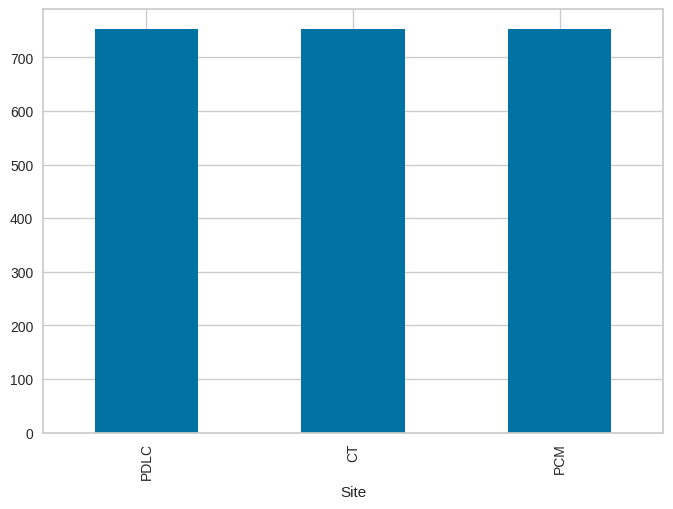

In [10]:
# oversampling strategy
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

y_smote.value_counts().plot(kind='bar')
#plt.savefig('SMOTE_distribution.png',dpi=200, bbox_inches='tight')
y_smote.value_counts()

#### We have created a balanced synthetic data set with 752 cases per class.

In [12]:
# Creating final resampled dataset
smote_data = X_smote
smote_data['Site'] = y_smote

In [13]:
# Experiment setup 

experiment = setup(data=smote_data, target= 'Site',train_size=0.8, session_id=123)

,Description,Value
0,Session id,123
1,Target,Site
2,Target type,Multiclass
3,Target mapping,"CT: 0, PCM: 1, PDLC: 2"
4,Original data shape,"(2256, 46)"
5,Transformed data shape,"(2256, 46)"
6,Transformed train set shape,"(1804, 46)"
7,Transformed test set shape,"(452, 46)"
8,Numeric features,45
9,Preprocess,True


In [22]:
remove_metric('MCC')
remove_metric('Kappa')
remove_metric('AUC')
#'AUC', , 'MCC'

In [14]:
rf = create_model('rf',n_estimators=200,
                  min_samples_leaf=5,
                  class_weight="balanced", 
                  criterion='entropy',
                  random_state=42)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9779,0.9980,0.9779,0.9779,0.9779,0.9668,0.9668
1,0.9558,0.9970,0.9558,0.9574,0.9560,0.9337,0.9343
2,0.9834,0.9999,0.9834,0.9842,0.9835,0.9751,0.9755
3,0.9890,0.9991,0.9890,0.9890,0.9889,0.9834,0.9835
4,0.9667,0.9967,0.9667,0.9672,0.9668,0.9500,0.9501
5,0.9556,0.9961,0.9556,0.9557,0.9556,0.9333,0.9334
6,0.9500,0.9973,0.9500,0.9503,0.9498,0.9250,0.9253
7,0.9833,0.9984,0.9833,0.9833,0.9833,0.9750,0.9750
8,0.9667,0.9955,0.9667,0.9670,0.9667,0.9500,0.9502


In [15]:
X_train = get_config(variable="X_train")
y_train = get_config(variable="y_train")

X_test = get_config(variable="X_test")
y_test = get_config(variable="y_test")
y_test.value_counts()

Site
PCM     151
PDLC    151
CT      150
Name: count, dtype: int64

In [16]:
tuned_model = tune_model(rf, n_iter=10, 
                         tuner_verbose=True, 
                         optimize='F1', 
                         custom_grid = 
                         {'criterion': ['entropy'],              
                          'min_samples_leaf':[5, 10, 15, 20, 25, 30],
                           'n_estimators':[10,50,100,200] })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9779,0.9974,0.9779,0.9779,0.9779,0.9668,0.9668
1,0.9448,0.9973,0.9448,0.9464,0.9449,0.9171,0.9178
2,0.9834,1.0000,0.9834,0.9842,0.9834,0.9751,0.9755
3,0.9890,0.9989,0.9890,0.9890,0.9889,0.9834,0.9835
4,0.9667,0.9978,0.9667,0.9672,0.9668,0.9500,0.9501
5,0.9389,0.9960,0.9389,0.9389,0.9388,0.9083,0.9084
6,0.9556,0.9967,0.9556,0.9557,0.9555,0.9333,0.9335
7,0.9778,0.9986,0.9778,0.9779,0.9778,0.9667,0.9667
8,0.9667,0.9946,0.9667,0.9670,0.9667,0.9500,0.9502


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Calculating SHAP Values

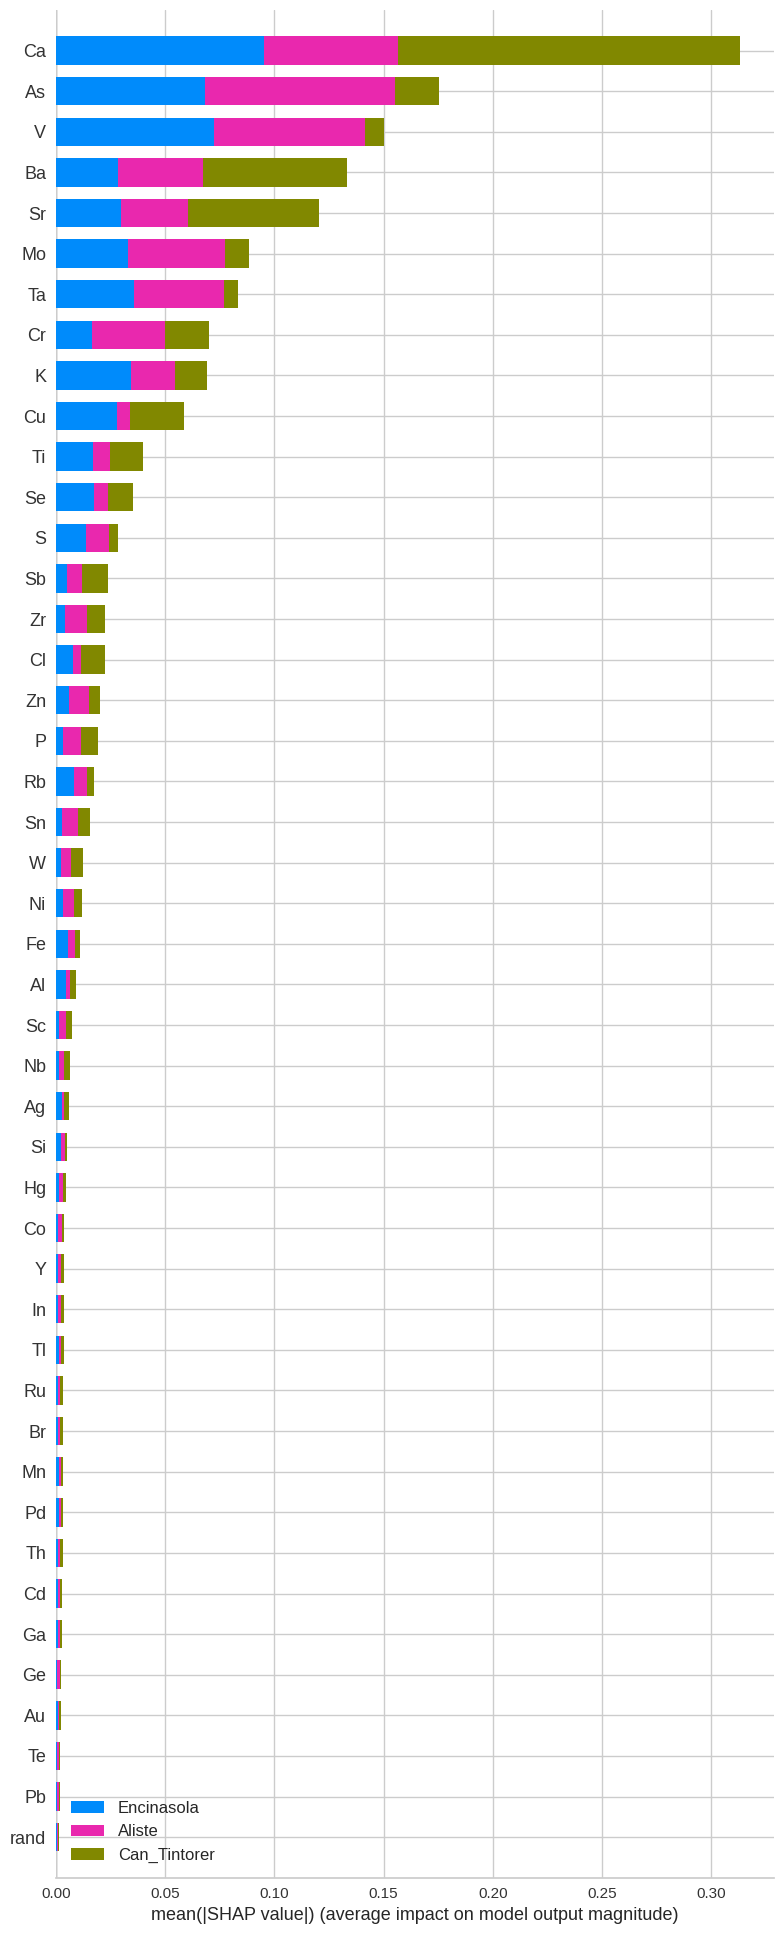

In [18]:
%matplotlib inline
interpret_model(tuned_model, class_names=['Can_Tintorer', 'Encinasola', 'Aliste'],max_display= 46)#,save=True)


In [40]:
tuned_model_score_grid = pull()
#tuned_model_score_grid.to_csv('./TABLES/20240814_tunedClassifierScore.csv')
tuned_model_score_grid

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9834,0.9834,0.9842,0.9834
1,0.9613,0.9613,0.9626,0.9614
2,0.9890,0.9890,0.9891,0.9889
3,0.9834,0.9834,0.9836,0.9835
4,0.9611,0.9611,0.9611,0.9611
5,0.9778,0.9778,0.9785,0.9778
6,0.9722,0.9722,0.9726,0.9722
7,0.9778,0.9778,0.9779,0.9778
8,0.9611,0.9611,0.9619,0.9611


### Model Calibration:
This function calibrates the probability of a given estimator using isotonic or logistic regression. The output of this function is a score grid with CV scores by fold.
By default function uses Logistic regression model to transform probabilities.
We chose this method to take into account the following library documentation [warning](https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.calibrate_model) and avoid overfitting. 


In [43]:
X_test = get_config(variable="X_test")
y_test = get_config(variable="y_test")
y_test.value_counts()

PCM     151
PDLC    151
CT      150
Name: Site, dtype: int64

In [ ]:
stop


In [ ]:
#The calibrated model evaluated against test data
last_training_predictions = predict_model(cal_model)

y_true = y_test
y_pred = last_training_predictions['prediction_label']
class_rep = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
#class_rep.to_csv('./TABLES/20240823_classificationReportTestData.csv')
class_rep


In [44]:
#Eliminación recursiva de variables usando validación cruzada:  https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification


rvcdf = training_data  

# Separar características (X) y variable objetivo (y)
X = rvcdf.drop(['Site', 'rand'], axis=1)
y = rvcdf['Site']
rvcdf['Site'].value_counts()

CT      602
PCM     601
PDLC    601
Name: Site, dtype: int64

In [ ]:
X.columns

We have used a recursive variable elimination procedure to establish the optimal number of variables necessary for the development of the classification. More details in [NOTAS](http://localhost:8888/lab/tree/NOTAS.ipynb)20240908 note

In [ ]:
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import matplotlib.pyplot as plt
from collections import Counter
# Assume X is your feature matrix and feature_names is a list of your feature names
# If you don't have feature_names, you can create them like this:
#feature_names = [f"feature_{i}" for i in range(X.shape[1])]
feature_names = X.columns
def run_rfecv(X, y, tuned_model, random_state):
    np.random.seed(random_state)  # Set seed for any numpy operations
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    rfecv = RFECV(estimator=clone(tuned_model), step=2, cv=cv, scoring='accuracy')
    rfecv.fit(X, y)
    
    # Handle different scikit-learn versions
    if hasattr(rfecv, 'cv_results_'):
        # For newer scikit-learn versions
        grid_scores = rfecv.cv_results_['mean_test_score']
    elif hasattr(rfecv, 'grid_scores_'):
        # For older scikit-learn versions
        grid_scores = rfecv.grid_scores_
    else:
        raise AttributeError("RFECV object has neither 'cv_results_' nor 'grid_scores_' attribute")
    
    # Get the mask of selected features
    feature_mask = rfecv.support_
    
    return rfecv.n_features_, grid_scores, feature_mask

# Number of times to run the process
n_runs = 10

# Lists to store results
n_features_list = []
grid_scores_list = []
feature_masks = []

# Run the process multiple times
for i in range(n_runs):
    n_features, grid_scores, feature_mask = run_rfecv(X, y, tuned_model, random_state=i)
    n_features_list.append(n_features)
    grid_scores_list.append(grid_scores)
    feature_masks.append(feature_mask)

# Calculate average and variance of optimal number of features
avg_n_features = np.mean(n_features_list)
var_n_features = np.var(n_features_list)

print(f"Average optimal number of features: {avg_n_features:.2f}")
print(f"Variance in optimal number of features: {var_n_features:.2f}")

# Calculate average and variance of grid scores
avg_grid_scores = np.mean(grid_scores_list, axis=0)
var_grid_scores = np.var(grid_scores_list, axis=0)


# Print the range of optimal features
min_features = min(n_features_list)
max_features = max(n_features_list)
print(f"Range of optimal number of features: {min_features} to {max_features}")
feature_selection_counts = Counter()
for mask in feature_masks:
    feature_selection_counts.update(np.where(mask)[0])

total_runs = len(feature_masks)
consistent_features = [feature for feature, count in feature_selection_counts.items() 
                       if count == total_runs]
mostly_consistent_features = [feature for feature, count in feature_selection_counts.items() 
                              if count >= total_runs * 0.8]

# Map indices to feature names
consistent_feature_names = [feature_names[i] for i in consistent_features]
mostly_consistent_feature_names = [feature_names[i] for i in mostly_consistent_features]

print("\nFeatures selected in all runs:")
for idx, name in zip(consistent_features, consistent_feature_names):
    print(f"Index {idx}: {name}")

print("\nFeatures selected in at least 80% of runs:")
for idx, name in zip(mostly_consistent_features, mostly_consistent_feature_names):
    print(f"Index {idx}: {name}")



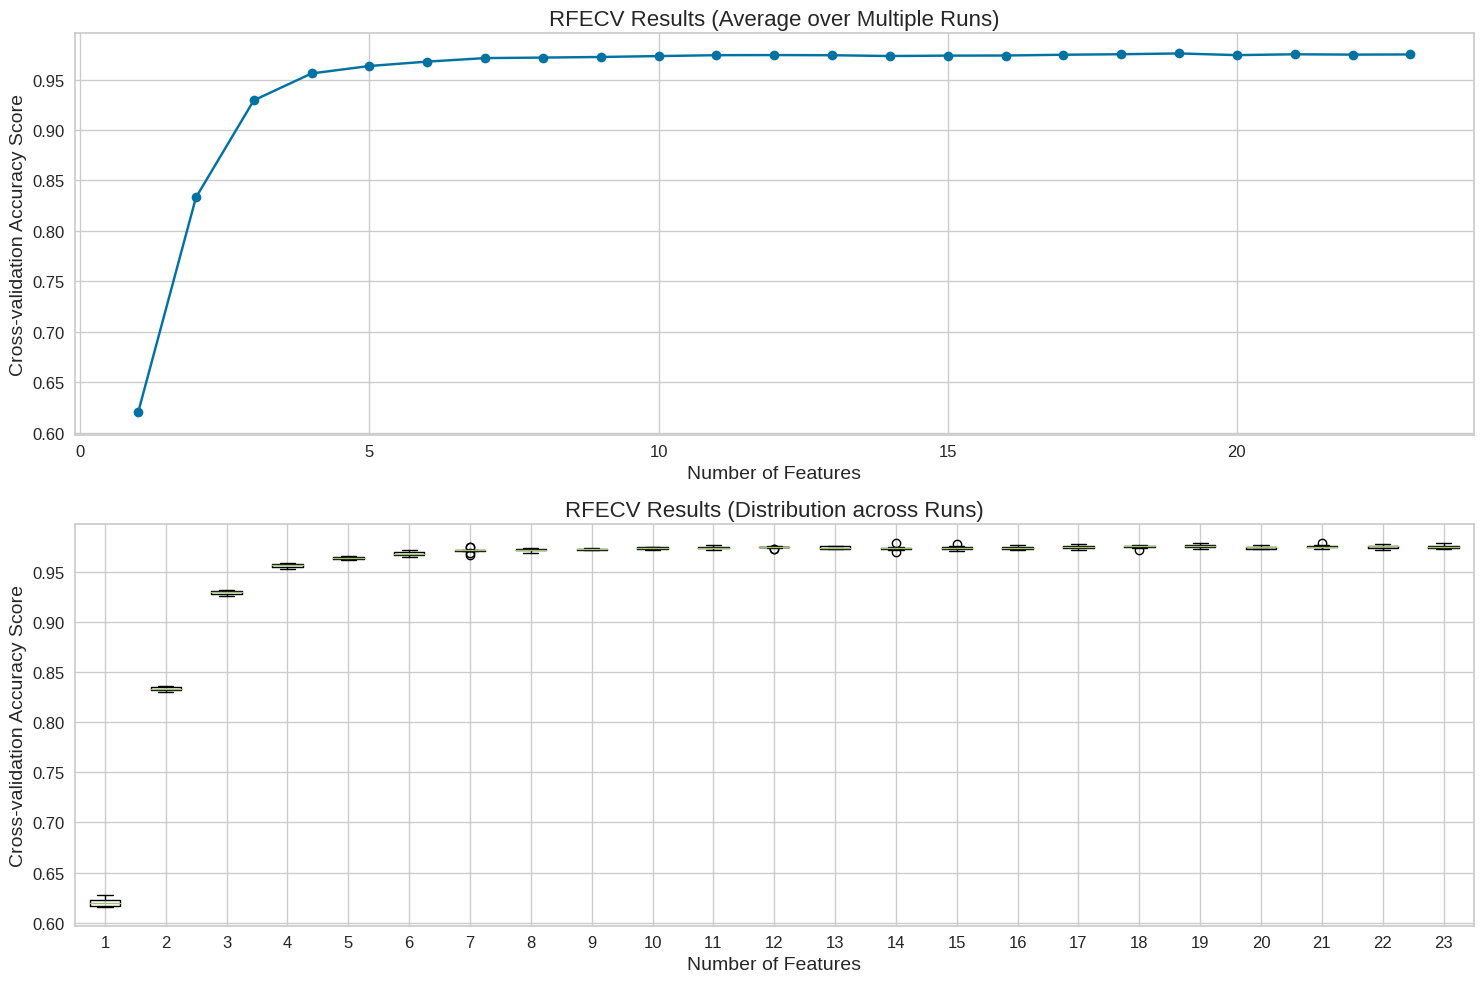

In [50]:


# Modificación en la parte de visualización
plt.figure(figsize=(15, 10))

# Subplot para el gráfico de líneas original
plt.subplot(2, 1, 1)
plt.errorbar(range(1, len(avg_grid_scores) + 1), avg_grid_scores, 
             yerr=np.sqrt(var_grid_scores), fmt='o-')
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cross-validation Accuracy Score', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('RFECV Results (Average over Multiple Runs)', fontsize=16)

# Subplot para el boxplot
plt.subplot(2, 1, 2)
# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))
plt.boxplot(grid_scores_transposed)
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cross-validation Accuracy Score', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(range(1, len(grid_scores_transposed) + 1), range(1, len(grid_scores_transposed) + 1), fontsize=12)
plt.title('RFECV Results (Distribution across Runs)', fontsize=16)

plt.savefig("./FIGURES/20250126RFECV_with_boxplot.tiff", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Opcionalmente, guardar la figura
#plt.savefig("./FIGURES/20250126RFECV_with_boxplot.png", dpi=300, bbox_inches='tight')

In [ ]:


# ... [El código anterior permanece igual hasta la parte de visualización] ...

# Modificación en la parte de visualización
plt.figure(figsize=(15, 8))

# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))

# Crear el boxplot
bp = plt.boxplot(grid_scores_transposed, positions=range(1, len(avg_grid_scores) + 1), 
                 widths=0.6, patch_artist=True)

# Personalizar el color de los boxplots
for box in bp['boxes']:
    box.set(facecolor='lightblue', edgecolor='blue', alpha=0.7)

# Superponer la línea de promedios con barras de error
plt.errorbar(range(1, len(avg_grid_scores) + 1), avg_grid_scores, 
             yerr=np.sqrt(var_grid_scores), fmt='ro-', ecolor='black', 
             capsize=5, capthick=2, linewidth=2, markersize=8)

# Configurar el gráfico
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cross-validation Accuracy Score', fontsize=14)
plt.title('RFECV Results: Average and Distribution Across Runs', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(range(1, len(avg_grid_scores) + 1), range(1, len(avg_grid_scores) + 1), fontsize=12)

# Añadir una leyenda
plt.plot([], [], 'ro-', linestyle='--',alpha=0.7, label='Average Score')
plt.plot([], [], 'b-', label='Median Score')
plt.fill([], [], color='lightblue', alpha=0.7, label='Score Distribution')
plt.legend(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Opcionalmente, guardar la figura
# plt.savefig("./FIGURES/20240916RFECV_combined.png", dpi=300, bbox_inches='tight')

In [ ]:


# ... [El código anterior permanece igual hasta la parte de visualización] ...

# Modificación en la parte de visualización
plt.figure(figsize=(15, 8))

# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))

# Crear el boxplot
bp = plt.boxplot(grid_scores_transposed, positions=range(1, len(avg_grid_scores) + 1), 
                 widths=0.6, patch_artist=True)

# Personalizar el color de los boxplots
for box in bp['boxes']:
    box.set(facecolor='lightblue', edgecolor='blue', alpha=0.7)

# Superponer la línea de promedios con barras de error
plt.errorbar(range(1, len(avg_grid_scores) + 1), avg_grid_scores, 
             yerr=np.sqrt(var_grid_scores), fmt='o-', ecolor='darkgray', 
             color='gray', capsize=3, capthick=1, linewidth=1, markersize=4, alpha=0.7)

# Configurar el gráfico
plt.xlabel('Number of Features', fontsize=16)
plt.ylabel('Cross-validation Accuracy Score', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(range(1, len(avg_grid_scores) + 1), range(1, len(avg_grid_scores) + 1), fontsize=14)

# Añadir una leyenda
plt.plot([], [], 'o-', color='gray', alpha=0.7, linewidth=1, markersize=4, label='Average Score')

plt.legend(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Opcionalmente, guardar la figura
#plt.savefig("./FIGURES/20240920RFECV_boxplot.jpg")

In [ ]:


# Importar el backend de Matplotlib
import matplotlib
#matplotlib.use('Agg')  # Usar el backend Agg para renderizar sin una ventana

# ... [El código anterior permanece igual hasta la parte de visualización] ...

# Modificación en la parte de visualización
fig, ax = plt.subplots(figsize=(15, 8))

# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))

# Crear el boxplot
#bp = ax.boxplot(grid_scores_transposed, positions=range(1, len(avg_grid_scores) + 1), 
#                widths=0.6, patch_artist=True)

# Personalizar el color de los boxplots
#for box in bp['boxes']:
#    box.set(edgecolor='gray', alpha=0.7)

# Superponer la línea de promedios con barras de error
#ax.errorbar(range(1, len(avg_grid_scores) + 1), avg_grid_scores, 
#            yerr=np.sqrt(var_grid_scores), fmt='o-', ecolor='darkgray', 
#            color='gray', capsize=3, capthick=1, linewidth=1, markersize=4, alpha=0.7)

# Configurar el gráfico
ax.set_xlabel('Number of Features', fontsize=16)
ax.set_ylabel('Cross-validation Accuracy Score', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(range(1, len(avg_grid_scores) + 1))
ax.set_xticklabels(range(1, len(avg_grid_scores) + 1))

# Añadir una leyenda
ax.plot([], [], 'o-', color='gray', alpha=0.7, linewidth=1, markersize=4, label='Average Score')
#ax.plot([], [], 'b-', label='Median Score')
#ax.fill([], [], color='lightblue', alpha=0.7, label='Score Distribution')
ax.legend(fontsize=14)

ax.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()

# Guardar la figura
#plt.savefig("./FIGURES/20240921RFECV_refined.png", dpi=300, bbox_inches='tight')

# Cerrar la figura para liberar memoria
#plt.close(fig)

# Si deseas mostrar la figura en un entorno interactivo, descomenta la siguiente línea:
plt.show()

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(range(1, len(avg_grid_scores) + 1), avg_grid_scores, 
             yerr=np.sqrt(var_grid_scores), fmt='o-')

#plt.title('RFECV Results (Average over Multiple Runs)')
plt.xlabel('Number of Features',fontsize=18)
plt.ylabel('Cross-validation Accuracy Score',fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.savefig("./FIGURES/20240916RFECV.png",dpi=300, bbox_inches='tight')
plt.show()


# Optional: Create a bar plot of feature importance
plt.figure(figsize=(12, 6))
feature_importance = [feature_selection_counts[i] / total_runs for i in range(len(feature_names))]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(len(feature_importance))
plt.barh(pos, [feature_importance[i] for i in sorted_idx])
plt.yticks(pos, [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance (Fraction of Runs Selected)')
plt.title('Feature Importance Across Multiple Runs')
plt.tight_layout()
plt.show()


20241001

Probando visualizar con una region sombreada en lugar de barras de error

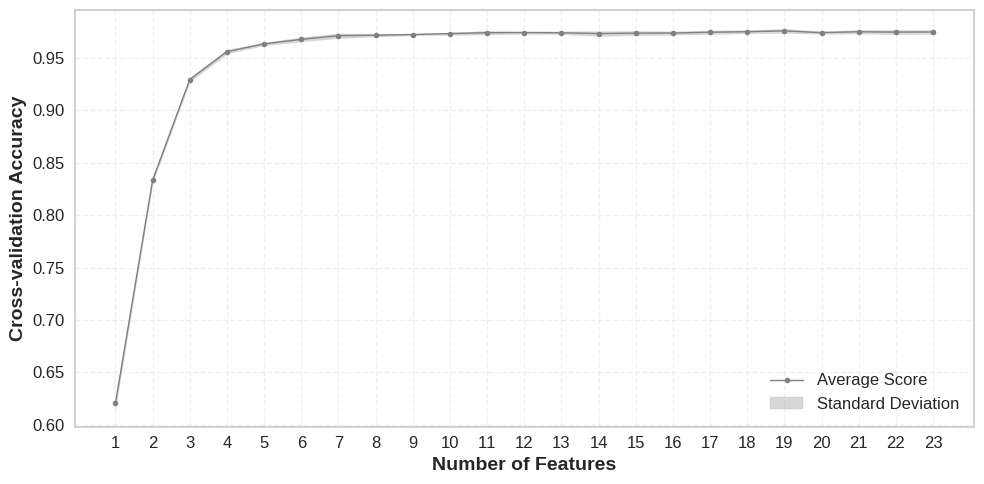

In [57]:

# Importar el backend de Matplotlib
import matplotlib
#matplotlib.use('Agg')  # Usar el backend Agg para renderizar sin una ventana

# ... [El código anterior permanece igual hasta la parte de visualización] ...

# Modificación en la parte de visualización
fig, ax = plt.subplots(figsize=(10, 5))

# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))

# Crear el boxplot
#bp = ax.boxplot(grid_scores_transposed, positions=range(1, len(avg_grid_scores) + 1), 
#                widths=0.6, patch_artist=True)

# Personalizar el color de los boxplots
#for box in bp['boxes']:
#    box.set(facecolor='lightblue', edgecolor='blue', alpha=0.7)

# Calcular los límites superior e inferior para la región sombreada
x = range(1, len(avg_grid_scores) + 1)
lower_bound = avg_grid_scores - np.sqrt(var_grid_scores)
upper_bound = avg_grid_scores + np.sqrt(var_grid_scores)

# Dibujar la región sombreada
ax.fill_between(x, lower_bound, upper_bound, color='gray', alpha=0.3)

# Dibujar la línea de promedios
ax.plot(x, avg_grid_scores, 'o-', color='gray', linewidth=1, markersize=4)

# Configurar el gráfico
ax.set_xlabel('Number of Features',fontweight='bold', fontsize=14)
ax.set_ylabel('Cross-validation Accuracy',fontweight='bold', fontsize=14)
#ax.set_title('RFECV Results: Distribution and Average Across Runs', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(range(1, len(avg_grid_scores) + 1))
ax.set_xticklabels(range(1, len(avg_grid_scores) + 1))

# Añadir una leyenda
ax.plot([], [], 'o-', color='gray', linewidth=1, markersize=4, label='Average Score')
ax.fill([], [], color='gray', alpha=0.3, label='Standard Deviation')
#ax.plot([], [], 'b-', label='Median Score')
#ax.fill([], [], color='lightblue', alpha=0.7, label='Score Distribution')
ax.legend(fontsize=12)

ax.grid(True, linestyle='--', alpha=0.3)

fig.tight_layout()

# Guardar la figura
plt.savefig("./FIGURES/20250126RFECV_refined_shaded_only.png", dpi=300, bbox_inches='tight')

# Cerrar la figura para liberar memoria
#plt.close(fig)

# Si deseas mostrar la figura en un entorno interactivo, descomenta la siguiente línea:
plt.show()

In [ ]:
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import matplotlib.pyplot as plt
from collections import Counter
# Importar el backend de Matplotlib
import matplotlib
matplotlib.use('Agg')  # Usar el backend Agg para renderizar sin una ventana

# ... [El código anterior permanece igual hasta la parte de visualización] ...

# Modificación en la parte de visualización
fig, ax = plt.subplots(figsize=(15, 8))

# Transponer grid_scores_list para que cada columna represente un número de características
grid_scores_transposed = list(map(list, zip(*grid_scores_list)))

# Calcular los cuartiles para cada número de características
lower_quartiles = [np.percentile(scores, 25) for scores in grid_scores_transposed]
medians = [np.median(scores) for scores in grid_scores_transposed]
upper_quartiles = [np.percentile(scores, 75) for scores in grid_scores_transposed]

# Calcular los límites para el área sombreada
x = range(1, len(avg_grid_scores) + 1)
lower_bound = lower_quartiles
upper_bound = upper_quartiles

# Dibujar el área sombreada (reemplazando los boxplots)
ax.fill_between(x, lower_bound, upper_bound, color='lightblue', alpha=0.7)

# Dibujar la línea de medianas
ax.plot(x, medians, '-', color='blue', linewidth=0.7, label='Median Score')

# Dibujar la línea de promedios
ax.plot(x, avg_grid_scores, 'o-', color='grey', linewidth=0.5, markersize=2, label='Average Score')

# Configurar el gráfico
ax.set_xlabel('Number of Features', fontsize=14)
ax.set_ylabel('Cross-validation Accuracy Score', fontsize=14)
ax.set_title('RFECV Results: Distribution and Average Across Runs', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(range(1, len(avg_grid_scores) + 1))
ax.set_xticklabels(range(1, len(avg_grid_scores) + 1))

# Añadir una leyenda
ax.fill([], [], color='lightblue', alpha=0.7, label='IQR (25th to 75th percentile)')
ax.legend(fontsize=12)

ax.grid(True, linestyle='--', alpha=0.3)
fig.tight_layout()

# Guardar la figura
plt.savefig("./FIGURES/20241001RFECV_refined_shaded_boxplots2.png", dpi=300, bbox_inches='tight')

# Cerrar la figura para liberar memoria
plt.close(fig)

# Si deseas mostrar la figura en un entorno interactivo, descomenta la siguiente línea:
# plt.show()

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.axhline(y=0.949, color='red', linestyle='--', label='Full model performance')
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

# Para ver las características seleccionadas:
selected_features = X.columns[rfecv.support_]
print("Selected features:", selected_features)

In [42]:
cal_model = calibrate_model(tuned_model)
cal_model

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9779,0.9779,0.9782,0.9779
1,0.9503,0.9503,0.9511,0.9504
2,0.9890,0.9890,0.9891,0.9889
3,0.9834,0.9834,0.9836,0.9835
4,0.9500,0.9500,0.9503,0.9501
5,0.9611,0.9611,0.9624,0.9612
6,0.9722,0.9722,0.9726,0.9722
7,0.9722,0.9722,0.9726,0.9722
8,0.9667,0.9667,0.9667,0.9666


CalibratedClassifierCV(cv=5, ensemble=True,
                       estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced',
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        monotonic_cst=None,
                                                        n_estimators=100,
                                                        n_jobs=-1,
                                                        oob_score=False,
                                                        random_state=123,
                                                        verbose=0,
                                                        warm_start=False),
                       method='sigmoid', n_jobs=None)

In [ ]:
final_model = finalize_model(cal_model)


In [ ]:
unseen_predictions = predict_model(final_model, data=vs1)

#x = unseen_predictions['Site'] == unseen_predictions['Label']
#unseen_predictions['error'] = x


unseen_predictions

In [ ]:
y_true_vs1 = unseen_predictions['Site']
y_pred_vs1 = unseen_predictions['prediction_label']
class_rep_vs1 = pd.DataFrame(classification_report(y_true_vs1, y_pred_vs1, output_dict=True)).T
#class_rep_vs1.to_csv('./TABLES/20240826_classificationReportVs1.csv')
class_rep_vs1

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_vs1,y_pred_vs1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= ['Garraf', 'Terena', 'Aliste'])
disp.plot(cmap='Greens')
#plt.savefig("./FIGURES/20240826_Vortex2VS1_ConfMatrix.png",bbox_inches='tight')


In [ ]:
# Guardamos el archivo producto de las predicciones a los datos de validación para posteriores análisis
unseen_predictions.to_csv("./DATA/20240821_VFSPredicitons.csv")


### Save the Model
This function saves the transformation pipeline and trained model object into the current working directory as a pickle file for later use.

In [ ]:
save_model(final_model, model_name = '/home/dsg/VORTEX_FINAL/PRODUCTION/models/Full_model',verbose=True)